<center><a target="_blank" href="https://academy.constructor.org/">
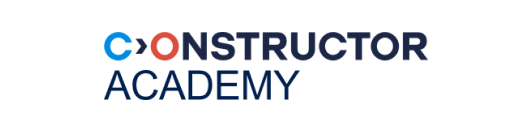</a> </center>
<hr />

# <h1 align="center"> Feed-forward NNs for Structured Data Classification </h1>

<hr />
<center>Constructor Academy, 2024</center>


## Introduction

The idea of this exercise is to continue the task of structured data classification using neural networks, starting from a raw
CSV file. Our data includes both numerical and categorical features. You will experiment with more aspects of NN architecture in this exercise as compared to what you learnt on Day 1

### The dataset

[Our dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the
Cleveland Clinic Foundation for Heart Disease.
It's a CSV file with 303 rows. Each row contains information about a patient (a
**sample**), and each column describes an attribute of the patient (a **feature**). We
use the features to predict whether a patient has a heart disease (**binary
classification**).

Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

## Key Objectives - Day 2


1. Your key task is to perform a binary classification problem to predict heart disease based on the given data by splitting it into train-valid-test datasets

2. You will experiment more aspects of Dense NN models like layer activations, learning rates, regularization

3. You will also plot learning curves to visualize training performance over epochs

4. You will also evaluate the performance of the models on the test dataset

5. You will continue using class weights to tackle class imbalance



## Load Dependencies

In [25]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
import pandas as pd

In [26]:
tf.random.set_seed(42)

## Load the dataset

Let's download the data and load it into a Pandas dataframe:

In [27]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

The dataset includes 303 samples with 14 columns per sample (13 features, plus the target
label):

In [28]:
df.shape

(303, 14)

Here's a preview of a few samples:

In [29]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [30]:
df.thal.value_counts()

normal        168
reversible    115
fixed          18
1               1
2               1
Name: thal, dtype: int64

we have two values in the thal column that has no meaning, so we will remove those rows

In [31]:
df = df[~df.thal.isin(['1','2'])]

The last column, "target", indicates whether the patient has a heart disease (1) or not
(0).

## Check the distribution of the target column

In [32]:
df.target.value_counts()

0    218
1     83
Name: target, dtype: int64

## Task 1: Split Dataset into Train, Validation and Test Datasets

Use stratified sampling to ensure similar `target` class distribution in the dataset splits when using `train_test_split()`

Use a split of 60:20:20 for train-valid-test splits
For reproducibility set the `random_state` to `42`

In [33]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='target')
y = df[['target']]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, random_state=42, test_size=0.4, stratify=y
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, random_state=42, test_size=0.5, stratify=y_temp
)

In [34]:
X_train.shape, X_valid.shape, X_test.shape

((180, 13), (60, 13), (61, 13))

In [35]:
y_train.value_counts()

target
0         130
1          50
dtype: int64

In [36]:
y_valid.value_counts()

target
0         44
1         16
dtype: int64

In [37]:
y_test.value_counts()

target
0         44
1         17
dtype: int64

In [38]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [39]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,target
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,54.571429,0.677741,3.126246,131.684385,246.817276,0.146179,0.996678,149.308970,0.328904,1.061462,1.594684,0.677741,0.275748
std,9.041702,0.468120,1.008634,17.709415,52.186619,0.353874,0.988259,22.953015,0.470597,1.167295,0.617931,0.937623,0.447634
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,242.000000,0.000000,1.000000,152.000000,0.000000,0.800000,2.000000,0.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,165.000000,1.000000,1.600000,2.000000,1.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


## Task 2: Data Pre-processing

Recall the data pre-processing you had learnt during the ML week! Perform the following tasks to have clean and pre-processed datasets for your training, validation and test datasets.

Key Steps:

1. One-hot encode categorical data
2. Standard Scaling numerical data
3. Combine categorical and numeric data together into a single dataframe \ numpy array

Hints: Leverage code from [here](https://monolith.propulsion-home.ch/backend/api/momentum/materials/ds-materials/04_MachineLearning/day3/pages/MLG_D3_LC2_Classification_Models_Tackling_Class_Imbalance.html#Separate-categorical-and-numeric-columns) [pre-processing parts only]

In [40]:
cat_feats = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca', 'thal']
num_feats = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope']

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [42]:
categorical_transformer = Pipeline(steps=[
                                          ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                          ])

numeric_transformer = Pipeline(steps=[
                                      ("scaler", StandardScaler())
                                      ])

preprocessor = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer,
                                                       num_feats),
                                               ("cat", categorical_transformer,
                                                       cat_feats)
                                               ])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['age', 'trestbps', 'chol', 'thalach',
                                  'oldpeak', 'slope']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca',
                                  'thal'])])

In [43]:
X_train_proc = preprocessor.fit_transform(X_train)
X_valid_proc = preprocessor.transform(X_valid)
X_test_proc = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()

X_train_proc = pd.DataFrame(X_train_proc, columns=feature_names)
X_valid_proc = pd.DataFrame(X_valid_proc, columns=feature_names)
X_test_proc = pd.DataFrame(X_test_proc, columns=feature_names)

In [44]:
X_train_proc.head()

,num__age,num__trestbps,num__chol,num__thalach,num__oldpeak,num__slope,cat__sex_0,cat__sex_1,cat__cp_0,cat__cp_1,...,cat__restecg_2,cat__exang_0,cat__exang_1,cat__ca_0,cat__ca_1,cat__ca_2,cat__ca_3,cat__thal_fixed,cat__thal_normal,cat__thal_reversible
0,-1.083146,-0.903756,0.253956,1.585937,-0.914960,-0.950923,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.522576,-0.628127,-0.050537,0.579070,-0.026039,-0.950923,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.410462,-1.179385,-1.363665,-1.128226,-0.430094,-0.950923,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.047020,2.679417,1.490960,0.228855,-0.914960,-0.950923,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.934906,-0.076870,1.586114,-0.734234,0.539638,-0.950923,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [45]:
X_train_proc.shape

(180, 27)

## Task 3: Experimenting with NN layer activation functions

_[We know that our dataset is heavily imbalanced between the two classes, feel free to leverage the`class_weight` parameter in the `model.fit()` function and experiment with your own weights or use [compute class weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) from `sklearn`]_

__Run the following experiments separately to train multi-layer neural networks with different activation functions__, evaluate the performance by looking at learning curve plots and finally check the performance of each of the following models on the test dataset.

Key workflow:

- Build model using architecture specification based on experiment
- Plot learning curves from model training to visualize performance over epochs on training and validation data
- Use trained model to predict and evaluate performance on test data
- Build separate models for each experiment


### Experiment 1 -  3-layer NN with elu activation:  
- __3-Dense Hidden Layer, 32 units, `elu` activation function and `he_normal` as the kernel_initializer__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

<br>

### Experiment 2 -  3-layer NN with leakyrelu activation:  
- __3-Dense Hidden Layer, 32 units, LeakyReLU(alpha=0.3) activation function and `he_normal` as the kernel_initializer__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports



### Hint: Utility function for plotting learning curves

You can use the following function to plot the learning curves after training.

Remember to do the following during training:

```
history = model.fit(.......)

# to plot the curves
plot_metrics(history)
```

In [46]:
import matplotlib.pyplot as plt


def plot_metrics(history, experiment_name=None):

  keys = history.history.keys()
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  plt.figure(figsize=(12, 10))
  if experiment_name:
    plt.suptitle(experiment_name)
  for n, metric in enumerate(metrics):
    name = metric.capitalize()
    metric_name = [item for item in keys if metric in item and 'val_'+metric not in item][0]
    val_metric_name = [item for item in keys if 'val_'+metric in item][0]

    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric_name], color='b', label='Train')
    plt.plot(history.epoch, history.history[val_metric_name], color='r',
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

In [47]:
from sklearn.metrics import classification_report, confusion_matrix

def get_prediction_labels(model, dataset):
  pred_probas = model.predict(dataset)
  pred_probas = pred_probas.ravel()
  pred_labels = [1 if prob > 0.5 else 0 for prob in pred_probas]
  return pred_labels

def display_performance_metrics(actuals, predictions):
  print('Classification Report:')
  print(classification_report(actuals, predictions))
  print('Confusion Matrix:')
  return pd.DataFrame(confusion_matrix(actuals, predictions))

## Complete Task 3 Below

### Experiment 1 -  3-layer NN with elu activation:  
- __3-Dense Hidden Layer, 32 units, `elu` activation function and `he_normal` as the kernel_initializer__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [48]:
input_shape = X_train_proc.shape[1]
output_shape = y_train.shape[1]
learning_rate = 1e-4

model8 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(32, activation="elu", kernel_initializer="he_normal", input_shape=(input_shape,)),
                                    tf.keras.layers.Dense(32, activation="elu", kernel_initializer="he_normal"),
                                    tf.keras.layers.Dense(32, activation="elu", kernel_initializer="he_normal"),
                                    tf.keras.layers.Dense(output_shape, activation='sigmoid')
])

metrics = [
           'accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
]

model8.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics)

EPOCHS = 10000
BATCH_SIZE=32

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train.values), y=y_train.values.ravel())
class_weight = dict(enumerate(class_weight))

history8 = model8.fit(X_train_proc, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid_proc, y_valid),
                    callbacks=[early_stopping_cb],
                    class_weight=class_weight,
                    verbose=1) #kernel_initializer="he_normal"

Epoch 1/10000
6/6 [==============================] - 1s 48ms/step - loss: 0.7836 - accuracy: 0.6611 - precision_1: 0.3878 - recall_1: 0.3800 - val_loss: 0.6571 - val_accuracy: 0.7167 - val_precision_1: 0.4667 - val_recall_1: 0.4375
Epoch 2/10000
6/6 [==============================] - 0s 14ms/step - loss: 0.7553 - accuracy: 0.6722 - precision_1: 0.4118 - recall_1: 0.4200 - val_loss: 0.6421 - val_accuracy: 0.7167 - val_precision_1: 0.4706 - val_recall_1: 0.5000
Epoch 3/10000
6/6 [==============================] - 0s 13ms/step - loss: 0.7278 - accuracy: 0.6889 - precision_1: 0.4423 - recall_1: 0.4600 - val_loss: 0.6282 - val_accuracy: 0.7167 - val_precision_1: 0.4706 - val_recall_1: 0.5000
Epoch 4/10000
6/6 [==============================] - 0s 13ms/step - loss: 0.7043 - accuracy: 0.7056 - precision_1: 0.4717 - recall_1: 0.5000 - val_loss: 0.6153 - val_accuracy: 0.7167 - val_precision_1: 0.4706 - val_recall_1: 0.5000
Epoch 5/10000
6/6 [==============================] - 0s 14ms/step - loss

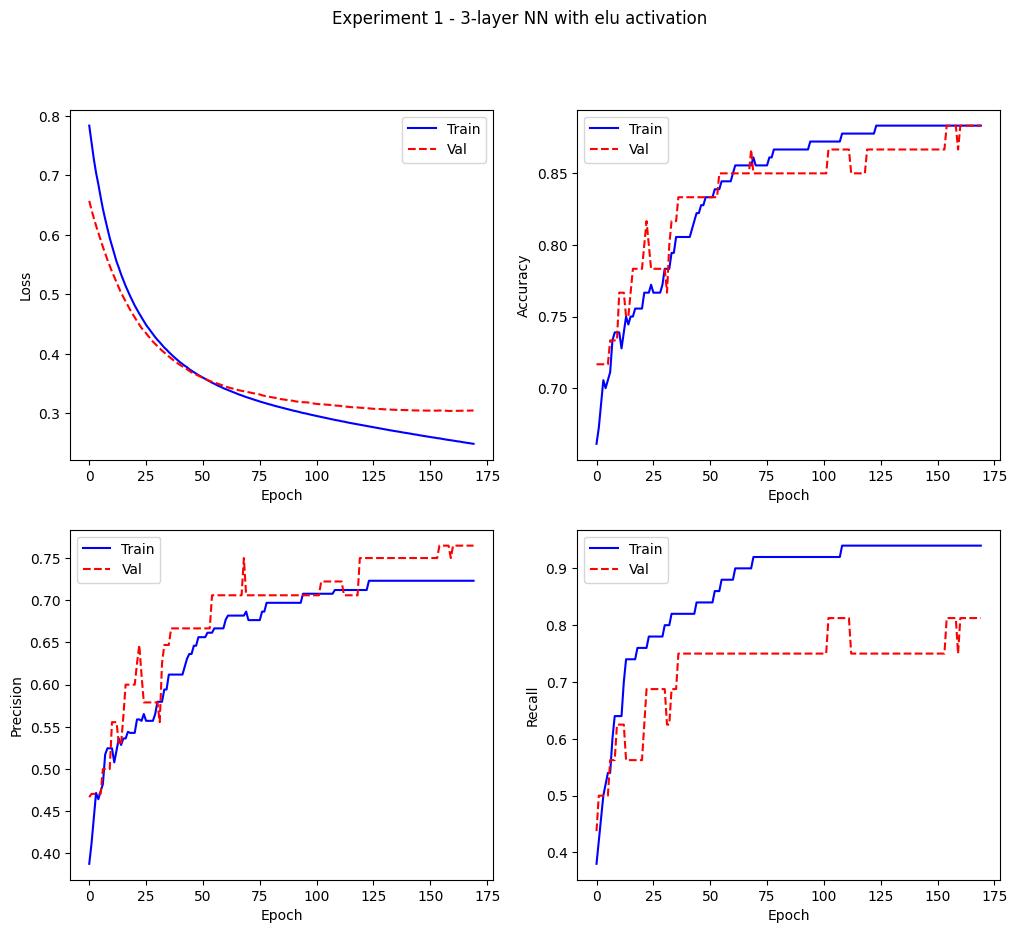

In [49]:
plot_metrics(history8, experiment_name="Experiment 1 - 3-layer NN with elu activation")

In [50]:
y_pred8 = get_prediction_labels(model8, X_test_proc)
display_performance_metrics(y_test, y_pred8)

2/2 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        44
           1       0.75      0.71      0.73        17

    accuracy                           0.85        61
   macro avg       0.82      0.81      0.81        61
weighted avg       0.85      0.85      0.85        61

Confusion Matrix:


,0,1
0,40,4
1,5,12


### Experiment 2 -  3-layer NN with leakyrelu activation:  
- __3-Dense Hidden Layer, 32 units, LeakyReLU(alpha=0.3) activation function and `he_normal` as the kernel_initializer__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [51]:
input_shape = X_train_proc.shape[1]
output_shape = y_train.shape[1]
learning_rate = 1e-4

model9 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(32, kernel_initializer="he_normal", input_shape=(input_shape,)),
                                    tf.keras.layers.LeakyReLU(alpha=0.3),
                                    tf.keras.layers.Dense(32, kernel_initializer="he_normal"),
                                    tf.keras.layers.LeakyReLU(alpha=0.3),
                                    tf.keras.layers.Dense(32, kernel_initializer="he_normal"),
                                    tf.keras.layers.LeakyReLU(alpha=0.3),
                                    tf.keras.layers.Dense(output_shape, activation='sigmoid')
])

metrics = [
           'accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
]

model9.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics)

EPOCHS = 10000
BATCH_SIZE=32

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

history9 = model9.fit(X_train_proc, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid_proc, y_valid),
                    callbacks=[early_stopping_cb],
                    class_weight=class_weight,
                    verbose=1)

Epoch 1/10000
6/6 [==============================] - 1s 88ms/step - loss: 1.1224 - accuracy: 0.2500 - precision_2: 0.2293 - recall_2: 0.7200 - val_loss: 1.3919 - val_accuracy: 0.2833 - val_precision_2: 0.2545 - val_recall_2: 0.8750
Epoch 2/10000
6/6 [==============================] - 0s 15ms/step - loss: 1.0917 - accuracy: 0.2556 - precision_2: 0.2308 - recall_2: 0.7200 - val_loss: 1.3479 - val_accuracy: 0.2833 - val_precision_2: 0.2545 - val_recall_2: 0.8750
Epoch 3/10000
6/6 [==============================] - 0s 14ms/step - loss: 1.0634 - accuracy: 0.2611 - precision_2: 0.2323 - recall_2: 0.7200 - val_loss: 1.3050 - val_accuracy: 0.2833 - val_precision_2: 0.2545 - val_recall_2: 0.8750
Epoch 4/10000
6/6 [==============================] - 0s 16ms/step - loss: 1.0354 - accuracy: 0.2667 - precision_2: 0.2338 - recall_2: 0.7200 - val_loss: 1.2643 - val_accuracy: 0.2667 - val_precision_2: 0.2407 - val_recall_2: 0.8125
Epoch 5/10000
6/6 [==============================] - 0s 18ms/step - loss

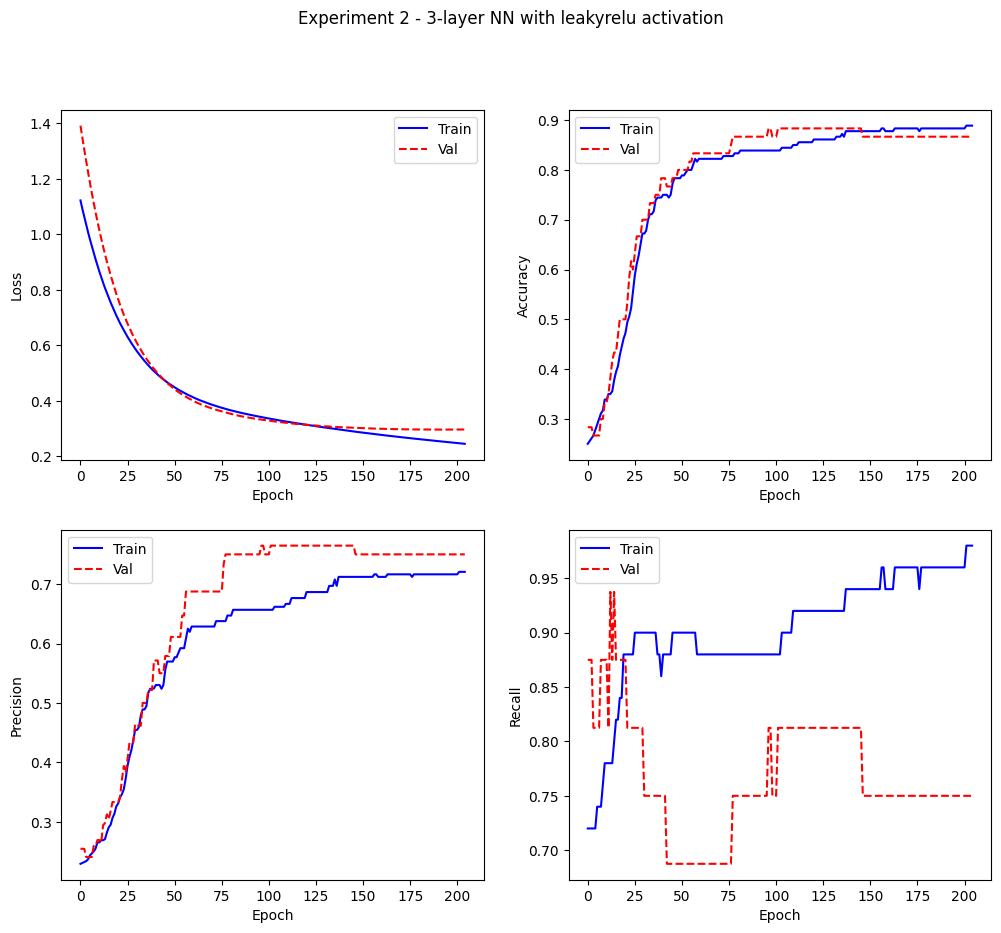

In [52]:
plot_metrics(history9, experiment_name="Experiment 2 - 3-layer NN with leakyrelu activation")

In [53]:
y_pred9 = get_prediction_labels(model9, X_test_proc)
display_performance_metrics(y_test, y_pred9)

2/2 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        44
           1       0.69      0.53      0.60        17

    accuracy                           0.80        61
   macro avg       0.76      0.72      0.73        61
weighted avg       0.79      0.80      0.79        61

Confusion Matrix:


,0,1
0,40,4
1,8,9


## Task 4: Regularization in NNs

_[We know that our dataset is heavily imbalanced between the two classes, feel free to leverage the`class_weight` parameter in the `model.fit()` function and experiment with your own weights or use [compute class weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) from `sklearn`]_

__Run the following experiments separately to train multi-layer neural networks with different methods of regularization__, evaluate the performance by looking at learning curve plots and finally check the performance of each of the following models on the test dataset.

We will try the following methods for regularization:
- BatchNormalization
- Dropout
- Layer regularizer with L2 kernel

Key workflow:

- Build model using architecture specification based on experiment
- Plot learning curves from model training to visualize performance over epochs on training and validation data
- Use trained model to predict and evaluate performance on test data
- Build separate models for each experiment


### Experiment 1 -  3-layer NN with BatchNorm:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- __Add batchnorm layer after each hidden layer__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

<br>

### Experiment 2 -  3-layer NN with Dropout:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- __Add dropout layers with rate = 0.2__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

<br>

### Experiment 3 -  3-layer NN with L2 Layer regularizer:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function and kernel_regularizer should be `tf.keras.regularizers.l2(0.001)`__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports



## Complete Task 4 Below

### Experiment 1 -  3-layer NN with BatchNorm:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- __Add batchnorm layer after each hidden layer__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [54]:
input_shape = X_train_proc.shape[1]
output_shape = y_train.shape[1]
learning_rate = 1e-4

model10 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(32, activation="relu", input_shape=(input_shape,)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(output_shape, activation='sigmoid')
])

metrics = [
           'accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
]

model10.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics)

EPOCHS = 10000
BATCH_SIZE=32

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

history10 = model10.fit(X_train_proc, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid_proc, y_valid),
                    callbacks=[early_stopping_cb],
                    class_weight=class_weight,
                    verbose=1)

Epoch 1/10000
6/6 [==============================] - 2s 61ms/step - loss: 0.8653 - accuracy: 0.4389 - precision_3: 0.2316 - recall_3: 0.4400 - val_loss: 0.6913 - val_accuracy: 0.4667 - val_precision_3: 0.2895 - val_recall_3: 0.6875
Epoch 2/10000
6/6 [==============================] - 0s 20ms/step - loss: 0.7998 - accuracy: 0.4833 - precision_3: 0.2637 - recall_3: 0.4800 - val_loss: 0.6851 - val_accuracy: 0.5000 - val_precision_3: 0.2941 - val_recall_3: 0.6250
Epoch 3/10000
6/6 [==============================] - 0s 22ms/step - loss: 0.8277 - accuracy: 0.4833 - precision_3: 0.2784 - recall_3: 0.5400 - val_loss: 0.6796 - val_accuracy: 0.5500 - val_precision_3: 0.3226 - val_recall_3: 0.6250
Epoch 4/10000
6/6 [==============================] - 0s 17ms/step - loss: 0.7883 - accuracy: 0.5333 - precision_3: 0.3068 - recall_3: 0.5400 - val_loss: 0.6759 - val_accuracy: 0.5833 - val_precision_3: 0.3448 - val_recall_3: 0.6250
Epoch 5/10000
6/6 [==============================] - 0s 18ms/step - loss

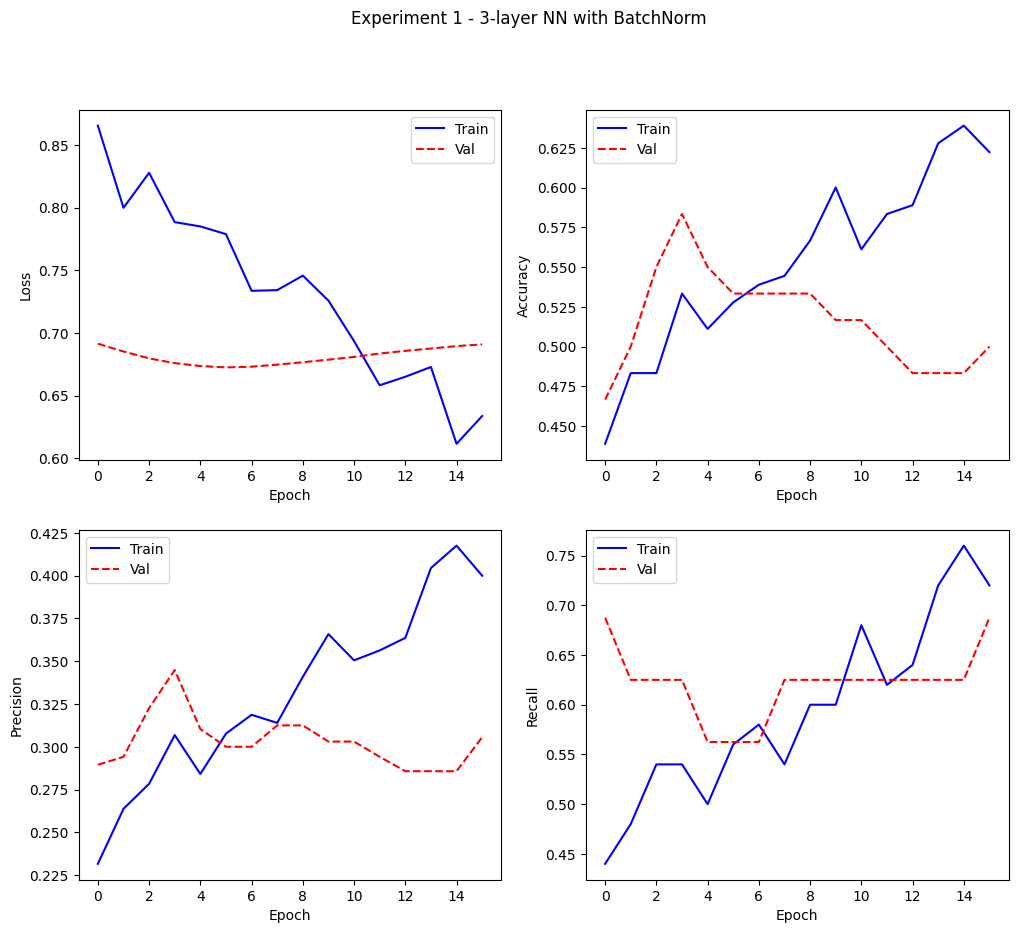

In [55]:
plot_metrics(history10, experiment_name="Experiment 1 - 3-layer NN with BatchNorm")

In [56]:
y_pred10 = get_prediction_labels(model10, X_test_proc)
display_performance_metrics(y_test, y_pred10)

2/2 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.61      0.69        44
           1       0.37      0.59      0.45        17

    accuracy                           0.61        61
   macro avg       0.58      0.60      0.57        61
weighted avg       0.68      0.61      0.63        61

Confusion Matrix:


,0,1
0,27,17
1,7,10



### Experiment 2 -  3-layer NN with Dropout:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- __Add dropout layers with rate = 0.2__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [57]:
input_shape = X_train_proc.shape[1]
output_shape = y_train.shape[1]
learning_rate = 1e-4

model11 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(32, activation="relu", input_shape=(input_shape,)),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(output_shape, activation='sigmoid')
])

metrics = [
           'accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
]

model11.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics)

EPOCHS = 10000
BATCH_SIZE=32

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

history11 = model11.fit(X_train_proc, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid_proc, y_valid),
                    callbacks=[early_stopping_cb],
                    class_weight=class_weight,
                    verbose=1)

Epoch 1/10000
6/6 [==============================] - 2s 44ms/step - loss: 0.6824 - accuracy: 0.5333 - precision_4: 0.3365 - recall_4: 0.7000 - val_loss: 0.6506 - val_accuracy: 0.7500 - val_precision_4: 0.5200 - val_recall_4: 0.8125
Epoch 2/10000
6/6 [==============================] - 0s 14ms/step - loss: 0.6643 - accuracy: 0.5278 - precision_4: 0.3451 - recall_4: 0.7800 - val_loss: 0.6486 - val_accuracy: 0.7500 - val_precision_4: 0.5200 - val_recall_4: 0.8125
Epoch 3/10000
6/6 [==============================] - 0s 14ms/step - loss: 0.6644 - accuracy: 0.5500 - precision_4: 0.3551 - recall_4: 0.7600 - val_loss: 0.6461 - val_accuracy: 0.7833 - val_precision_4: 0.5652 - val_recall_4: 0.8125
Epoch 4/10000
6/6 [==============================] - 0s 14ms/step - loss: 0.6760 - accuracy: 0.5444 - precision_4: 0.3462 - recall_4: 0.7200 - val_loss: 0.6436 - val_accuracy: 0.7833 - val_precision_4: 0.5652 - val_recall_4: 0.8125
Epoch 5/10000
6/6 [==============================] - 0s 13ms/step - loss

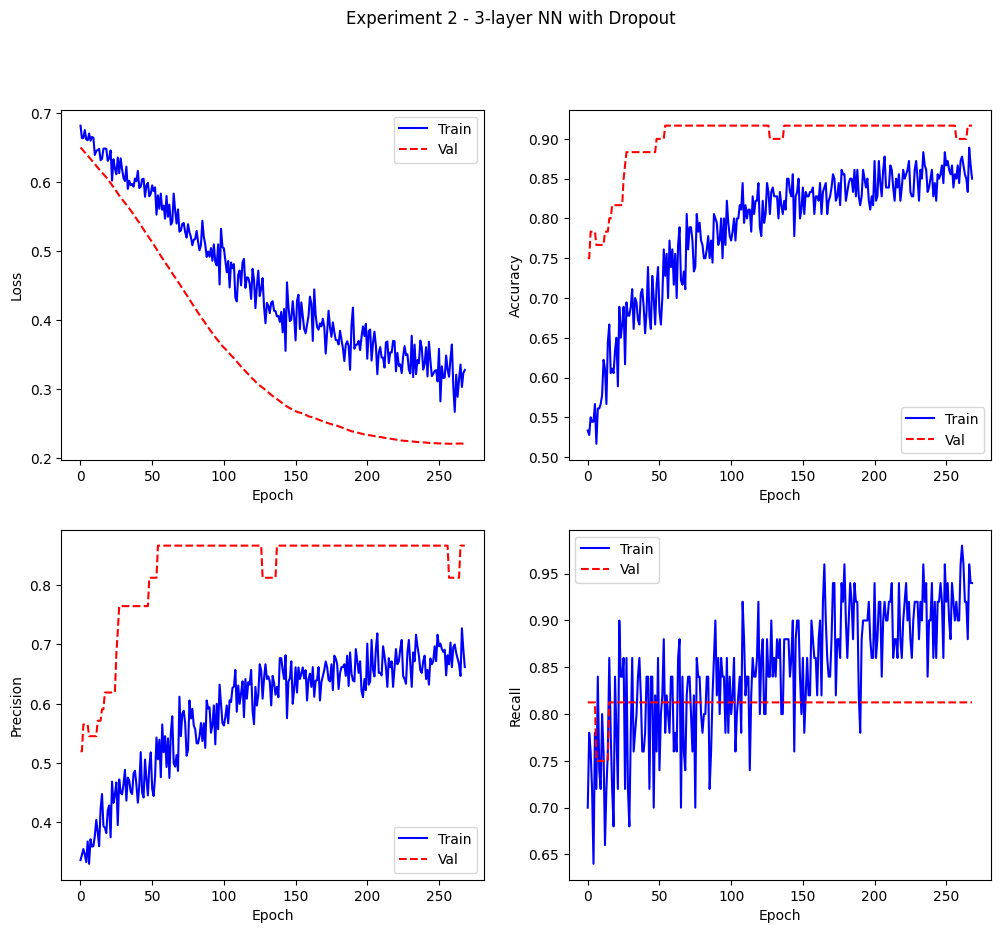

In [58]:
plot_metrics(history11, experiment_name="Experiment 2 - 3-layer NN with Dropout")

In [59]:
y_pred11 = get_prediction_labels(model11, X_test_proc)
display_performance_metrics(y_test, y_pred11)

2/2 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        44
           1       0.77      0.59      0.67        17

    accuracy                           0.84        61
   macro avg       0.81      0.76      0.78        61
weighted avg       0.83      0.84      0.83        61

Confusion Matrix:


,0,1
0,41,3
1,7,10


### Experiment 3 -  3-layer NN with L2 Layer regularizer:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function and kernel_regularizer should be `tf.keras.regularizers.l2(0.001)`__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __learning rate: 0.0001__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [60]:
input_shape = X_train_proc.shape[1]
output_shape = y_train.shape[1]
learning_rate = 1e-4

model12 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(32, activation="relu", input_shape=(input_shape,),
                                                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                                    tf.keras.layers.Dense(32, activation="relu",
                                                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                                    tf.keras.layers.Dense(32, activation="relu",
                                                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                                    tf.keras.layers.Dense(output_shape, activation='sigmoid')
])

metrics = [
           'accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
]

model12.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics)

EPOCHS = 10000
BATCH_SIZE=32

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

history12 = model12.fit(X_train_proc, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid_proc, y_valid),
                    callbacks=[early_stopping_cb],
                    class_weight=class_weight,
                    verbose=1)

Epoch 1/10000
6/6 [==============================] - 1s 42ms/step - loss: 0.8253 - accuracy: 0.7222 - precision_5: 0.5000 - recall_5: 0.0200 - val_loss: 0.7195 - val_accuracy: 0.7000 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/10000
6/6 [==============================] - 0s 13ms/step - loss: 0.8150 - accuracy: 0.7222 - precision_5: 0.5000 - recall_5: 0.0200 - val_loss: 0.7165 - val_accuracy: 0.7000 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/10000
6/6 [==============================] - 0s 12ms/step - loss: 0.8065 - accuracy: 0.7222 - precision_5: 0.5000 - recall_5: 0.0200 - val_loss: 0.7138 - val_accuracy: 0.7000 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/10000
6/6 [==============================] - 0s 13ms/step - loss: 0.7977 - accuracy: 0.7167 - precision_5: 0.3333 - recall_5: 0.0200 - val_loss: 0.7112 - val_accuracy: 0.7000 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 5/10000
6/6 [=====================

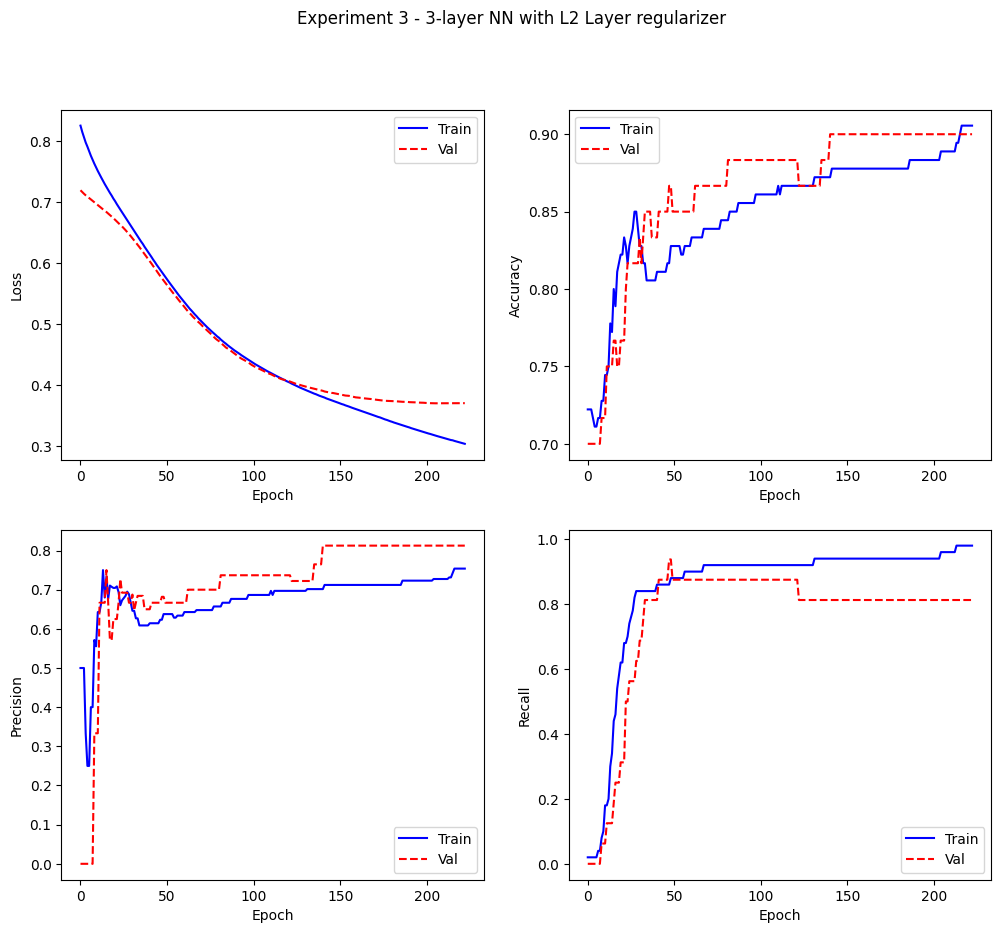

In [61]:
plot_metrics(history12, experiment_name="Experiment 3 - 3-layer NN with L2 Layer regularizer")

In [62]:
y_pred12 = get_prediction_labels(model12, X_test_proc)
display_performance_metrics(y_test, y_pred12)

2/2 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        44
           1       0.71      0.59      0.65        17

    accuracy                           0.82        61
   macro avg       0.78      0.75      0.76        61
weighted avg       0.81      0.82      0.81        61

Confusion Matrix:


,0,1
0,40,4
1,7,10


## Task 5: Learning Rate Scheduling in NNs

_[We know that our dataset is heavily imbalanced between the two classes, feel free to leverage the`class_weight` parameter in the `model.fit()` function and experiment with your own weights or use [compute class weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) from `sklearn`]_

__Run the following experiments separately to train multi-layer neural networks with different methods of learning rate schedulers__, evaluate the performance by looking at learning curve plots and finally check the performance of each of the following models on the test dataset.

We will try the following methods for LR scheduling:
- Exponential Decay
- Cosine Decay

__Recall: Learning Rate Schedulers help in increasing or decreasing learning rate with change in epochs to help coverge faster during NN training__

Key workflow:

- Build model using architecture specification based on experiment
- Plot learning curves from model training to visualize performance over epochs on training and validation data
- Use trained model to predict and evaluate performance on test data
- Build separate models for each experiment


### Experiment 1 -  3-layer NN with Exponential Decay LR Scheduler:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __initial learning rate: 0.001__
- __Use [ExponentialDecay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay) to build your own LR scheduler. Refer to [documentation](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/) for an example__
- __Use following config for the LR scheduler: `decay_steps=100,
    decay_rate=0.5, staircase=True` but feel free to experiment also__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

<br>

### Experiment 2 -  3-layer NN with Cosine Decay LR Scheduler:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __initial learning rate: 0.001__
- __Use [CosineDecay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecay) to build your own LR scheduler. Refer to [documentation](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/) for an example__
- __Use following config for the LR scheduler: `decay_steps=100 but feel free to experiment also__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports



## Complete Task 5 Below

### Experiment 1 -  3-layer NN with Exponential Decay LR Scheduler:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __initial learning rate: 0.001__
- __Use [ExponentialDecay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay) to build your own LR scheduler. Refer to [documentation](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/) for an example__
- __Use following config for the LR scheduler: `decay_steps=100,
    decay_rate=0.5, staircase=True` but feel free to experiment also__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [63]:
input_shape = X_train_proc.shape[1]
output_shape = y_train.shape[1]

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.5,
    staircase=True)

model13 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(32, activation="relu", input_shape=(input_shape,)),
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.Dense(output_shape, activation='sigmoid')
])

metrics = [
           'accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
]

model13.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics)

EPOCHS = 10000
BATCH_SIZE=32

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

class LearningRateTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lr = tf.keras.backend.eval(optimizer._current_learning_rate)
        print('\nLR is :', lr, '\n')

history13 = model13.fit(X_train_proc, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid_proc, y_valid),
                    callbacks=[early_stopping_cb, LearningRateTracker()],
                    class_weight=class_weight,
                    verbose=1)

Epoch 1/10000
1/6 [====>.........................] - ETA: 4s - loss: 0.7616 - accuracy: 0.3750 - precision_6: 0.3333 - recall_6: 0.8182
LR is : 0.001 

6/6 [==============================] - 1s 48ms/step - loss: 0.7009 - accuracy: 0.4167 - precision_6: 0.2932 - recall_6: 0.7800 - val_loss: 0.6895 - val_accuracy: 0.5333 - val_precision_6: 0.3421 - val_recall_6: 0.8125
Epoch 2/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.6699 - accuracy: 0.5000 - precision_6: 0.3182 - recall_6: 0.8750
LR is : 0.001 

6/6 [==============================] - 0s 14ms/step - loss: 0.6575 - accuracy: 0.6167 - precision_6: 0.4059 - recall_6: 0.8200 - val_loss: 0.6404 - val_accuracy: 0.7167 - val_precision_6: 0.4800 - val_recall_6: 0.7500
Epoch 3/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.6108 - accuracy: 0.7500 - precision_6: 0.5000 - recall_6: 0.8750
LR is : 0.001 

6/6 [==============================] - 0s 14ms/step - loss: 0.6259 - accuracy: 0.7833 - precision_6: 0.5775 

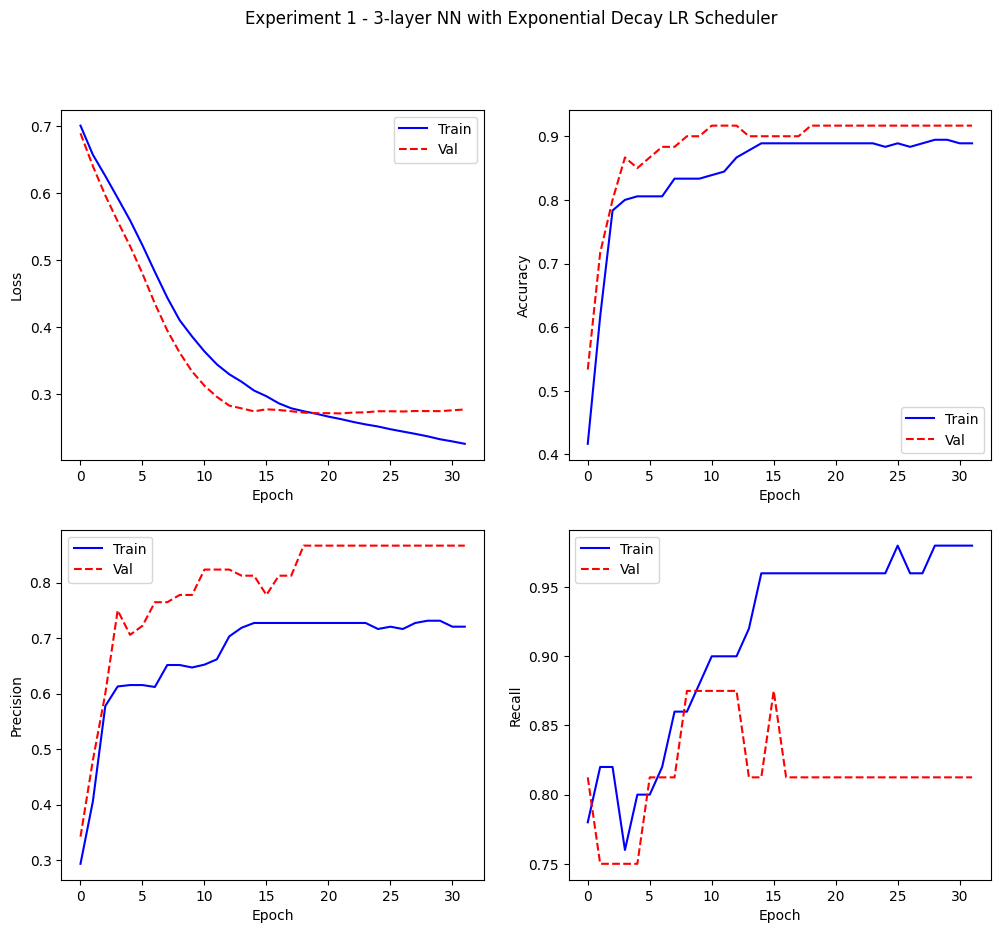

In [64]:
plot_metrics(history13, experiment_name="Experiment 1 - 3-layer NN with Exponential Decay LR Scheduler")

In [65]:
y_pred13 = get_prediction_labels(model13, X_test_proc)
display_performance_metrics(y_test, y_pred13)

2/2 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        44
           1       0.69      0.65      0.67        17

    accuracy                           0.82        61
   macro avg       0.78      0.77      0.77        61
weighted avg       0.82      0.82      0.82        61

Confusion Matrix:


,0,1
0,39,5
1,6,11


### Experiment 2 -  3-layer NN with Cosine Decay LR Scheduler:  
- __3-Dense Hidden Layer, 32 units, `relu` activation function__
- 1-Dense Output Layer, 1 unit, `sigmoid` activation function
- __initial learning rate: 0.001__
- __Use [CosineDecay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecay) to build your own LR scheduler. Refer to [documentation](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/) for an example__
- __Use following config for the LR scheduler: `decay_steps=100 but feel free to experiment also__
- __optimizer is Adam__
- metrics: 'accuracy', [precision](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Precision), [recall](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall)
- loss: [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
- __epochs: 10000__
- __Use the [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to stop training as soon as the validation loss doesn't decrease after 10 epochs i.e. `patience=10` and `monitor='val_loss'`__
- __Modify `class_weight` in `model.fit()`__
- batch size: 32
- use training data and validation data in `fit()` function
- use `predict()` on test data and show confusion matrix and classification reports

In [66]:
input_shape = X_train_proc.shape[1]
output_shape = y_train.shape[1]

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps=100)

model14 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(32, activation="relu", input_shape=(input_shape,)),
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.Dense(output_shape, activation='sigmoid')
])

metrics = [
           'accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
]

model14.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics)

EPOCHS = 10000
BATCH_SIZE=32

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

class LearningRateTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lr = tf.keras.backend.eval(optimizer._current_learning_rate)
        print('\nLR is :', lr, '\n')


history14 = model14.fit(X_train_proc, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid_proc, y_valid),
                    callbacks=[early_stopping_cb, LearningRateTracker()],
                    class_weight=class_weight,
                    verbose=1)

Epoch 1/10000
5/6 [========================>.....] - ETA: 0s - loss: 0.7202 - accuracy: 0.6500 - precision_7: 0.2857 - recall_7: 0.1277
LR is : 0.0009938442 

6/6 [==============================] - 1s 49ms/step - loss: 0.7024 - accuracy: 0.6667 - precision_7: 0.2727 - recall_7: 0.1200 - val_loss: 0.6431 - val_accuracy: 0.6833 - val_precision_7: 0.3333 - val_recall_7: 0.1875
Epoch 2/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.6396 - accuracy: 0.8125 - precision_7: 0.7500 - recall_7: 0.3750
LR is : 0.00097044045 

6/6 [==============================] - 0s 21ms/step - loss: 0.6559 - accuracy: 0.7833 - precision_7: 0.6897 - recall_7: 0.4000 - val_loss: 0.6099 - val_accuracy: 0.7167 - val_precision_7: 0.4545 - val_recall_7: 0.3125
Epoch 3/10000
5/6 [========================>.....] - ETA: 0s - loss: 0.6028 - accuracy: 0.8188 - precision_7: 0.6875 - recall_7: 0.5366
LR is : 0.0009303711 

6/6 [==============================] - 0s 46ms/step - loss: 0.6185 - accuracy: 0.8167 

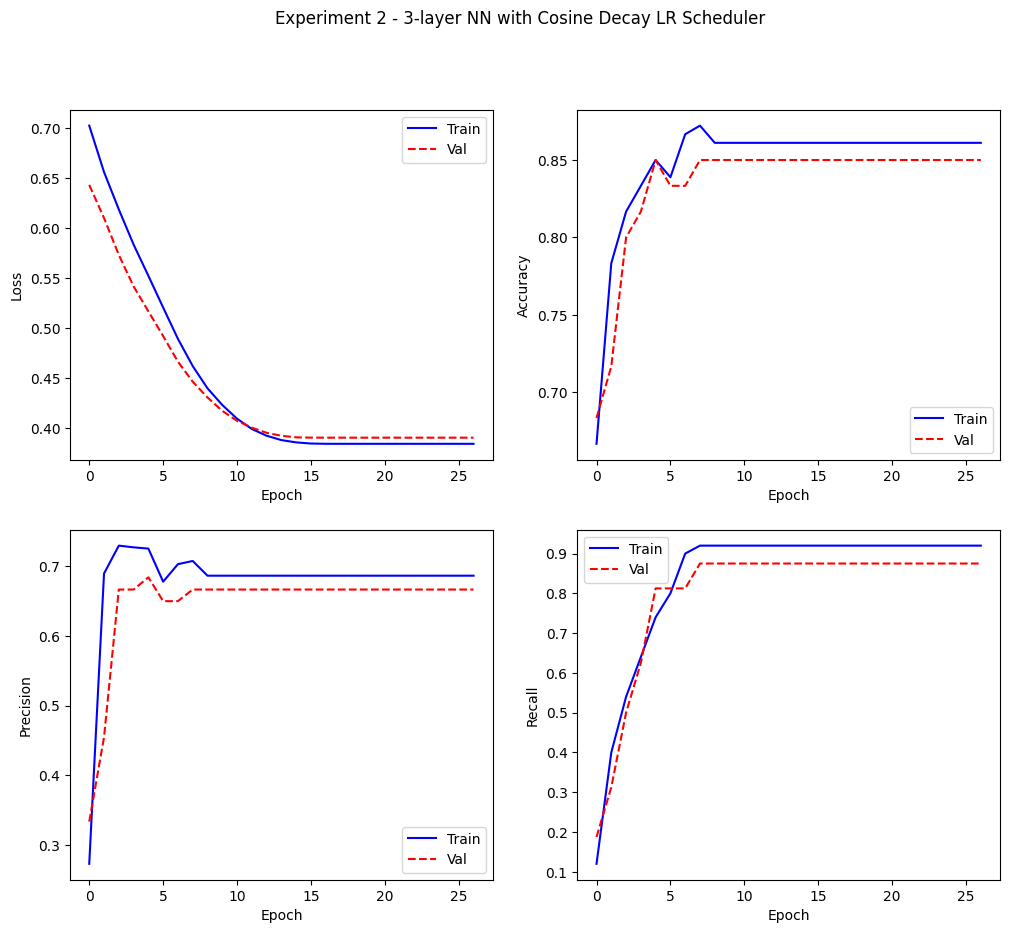

In [67]:
plot_metrics(history14, experiment_name="Experiment 2 - 3-layer NN with Cosine Decay LR Scheduler")

In [68]:
y_pred14 = get_prediction_labels(model14, X_test_proc)
display_performance_metrics(y_test, y_pred14)

2/2 [==============================] - 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        44
           1       0.60      0.71      0.65        17

    accuracy                           0.79        61
   macro avg       0.74      0.76      0.75        61
weighted avg       0.80      0.79      0.79        61

Confusion Matrix:


,0,1
0,36,8
1,5,12


## Optional Task: Hyperparameter Tuning with Keras Tuner

Try tuning layer hidden units and learning rate using Keras Tuner based on what you learnt during the live coding and see if you can come up with a better model.

[Live coding example](https://monolith.propulsion-home.ch/backend/api/momentum/materials/ds-materials/05_DeepLearning/day2/pages/DLG_D2_LC1_Training_NN.html#Hyperparameters)

In [69]:
!pip install -q -U keras-tuner

In [70]:
import keras_tuner as kt

In [71]:
def model_builder(hp):
    input_shape = X_train_proc.shape[1]
    output_shape = y_train.shape[1]
    model = tf.keras.Sequential()

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    model.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu', input_shape=(input_shape,)))
    model.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu'))
    model.add(tf.keras.layers.Dense(output_shape, activation = 'sigmoid'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from  0.001, 0.005 or 0.0001

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-3, 5e-3, 1e-4])

    metrics = [
           'accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
    ]

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = metrics)
    return model

In [72]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss',
                     max_epochs = 100,
                     factor = 3,
                     seed = 3, # any number just to try and make it reproducible as possible
        )

Reloading Tuner from ./untitled_project/tuner0.json


In [73]:
import IPython

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)

In [74]:
tuner.search(x=X_train_proc,
             y=y_train,
             epochs=10,
             batch_size=32,
             validation_data=(X_valid_proc, y_valid),
             callbacks=[ClearTrainingOutput()])

In [75]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hps.values

{'units': 448,
 'learning_rate': 0.001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [76]:
input_shape = X_train_proc.shape[1]
output_shape = y_train.shape[1]
learning_rate = best_hps.get('learning_rate')

model15 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(best_hps.get('units'), activation="relu", input_shape=(input_shape,)),
                                    tf.keras.layers.Dense(best_hps.get('units'), activation="relu"),
                                    tf.keras.layers.Dense(best_hps.get('units'), activation="relu"),
                                    tf.keras.layers.Dense(output_shape, activation='sigmoid')
])

metrics = [
           'accuracy',
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
]

model15.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics)

EPOCHS = 10000
BATCH_SIZE=32

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

history15 = model15.fit(X_train_proc, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid_proc, y_valid),
                    callbacks=[early_stopping_cb],
                    class_weight=class_weight,
                    verbose=1)

Epoch 1/10000
6/6 [==============================] - 1s 46ms/step - loss: 0.5732 - accuracy: 0.6722 - precision_8: 0.4505 - recall_8: 0.8200 - val_loss: 0.3662 - val_accuracy: 0.8500 - val_precision_8: 0.7692 - val_recall_8: 0.6250
Epoch 2/10000
6/6 [==============================] - 0s 16ms/step - loss: 0.3875 - accuracy: 0.8500 - precision_8: 0.6825 - recall_8: 0.8600 - val_loss: 0.3621 - val_accuracy: 0.8833 - val_precision_8: 0.7143 - val_recall_8: 0.9375
Epoch 3/10000
6/6 [==============================] - 0s 17ms/step - loss: 0.3195 - accuracy: 0.8444 - precision_8: 0.6528 - recall_8: 0.9400 - val_loss: 0.2888 - val_accuracy: 0.8833 - val_precision_8: 0.8000 - val_recall_8: 0.7500
Epoch 4/10000
6/6 [==============================] - 0s 15ms/step - loss: 0.2753 - accuracy: 0.8889 - precision_8: 0.7586 - recall_8: 0.8800 - val_loss: 0.2995 - val_accuracy: 0.8833 - val_precision_8: 0.7647 - val_recall_8: 0.8125
Epoch 5/10000
6/6 [==============================] - 0s 17ms/step - loss

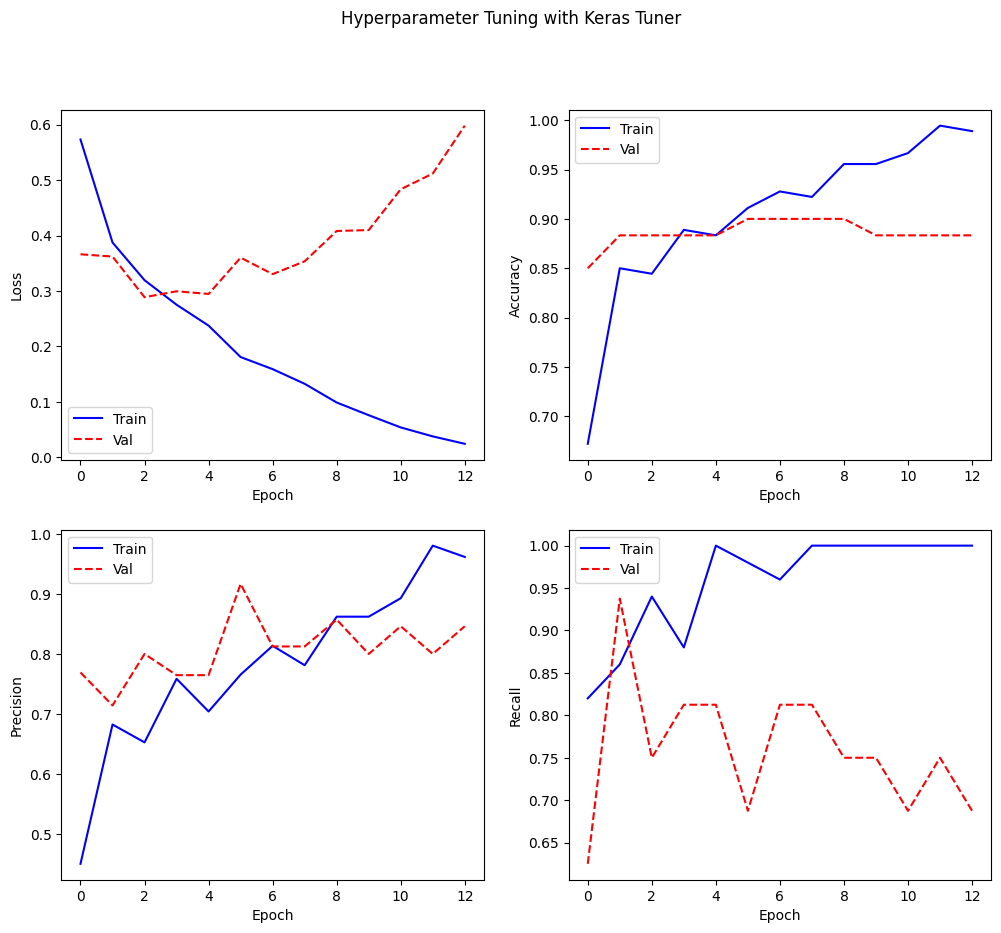

In [77]:
plot_metrics(history15, experiment_name="Hyperparameter Tuning with Keras Tuner")

In [78]:
y_pred15 = get_prediction_labels(model15, X_test_proc)
display_performance_metrics(y_test, y_pred15)

2/2 [==============================] - 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        44
           1       0.75      0.53      0.62        17

    accuracy                           0.82        61
   macro avg       0.79      0.73      0.75        61
weighted avg       0.81      0.82      0.81        61

Confusion Matrix:


,0,1
0,41,3
1,8,9
